In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model import MNISTNet
from sklearn.metrics import confusion_matrix
import itertools

In [21]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Set model to training mode
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        # Compute training accuracy
        pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
        total_correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_accuracy = 100. * total_correct / total_samples
    print(f'Training Accuracy: {train_accuracy:.2f}%')

In [7]:
def test(model, device, test_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({test_accuracy:.2f}%)\n')

In [8]:
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f'Using device: {device}')

    # Load MNIST dataset with transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Initialize model and optimizer
    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model for multiple epochs
    num_epochs = 10
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, epoch)

    # Evaluate on test set
    print("\nEvaluating on Test Set...")
    test(model, device, test_loader)

    # Save the trained model
    torch.save(model.state_dict(), "mnist_cnn.pt")
    print("Model saved as mnist_cnn.pt")

if __name__ == "__main__":
    main()


Using device: cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.15MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294886
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.304469
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.281143
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.069344
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.136560
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.075088
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.185885
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.134861
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.069875
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.077341
Training Accuracy: 93.93%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.112261
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.101821
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.039781
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.011657
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.029413
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.032773
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.163954
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.024959
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.036069
Train Epoch: 2 [57600/60000 (96%)]	L

<ipython-input-27-0bdeed4db372>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


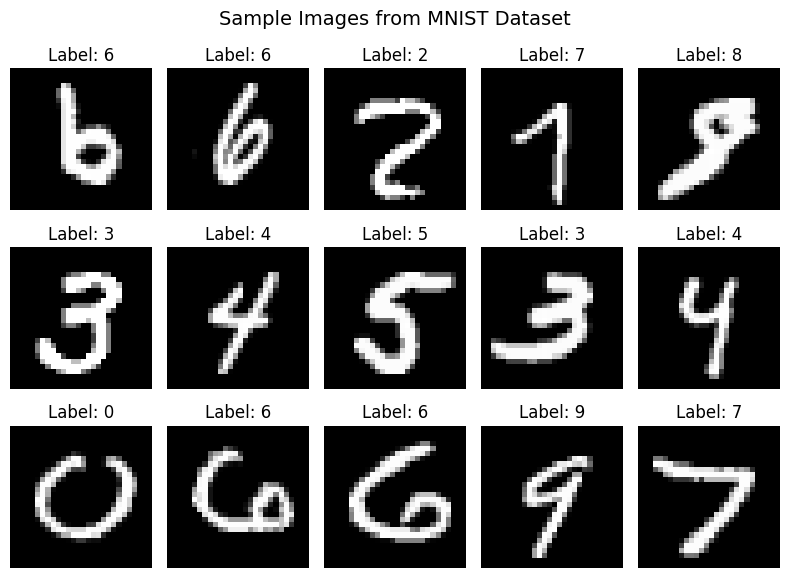

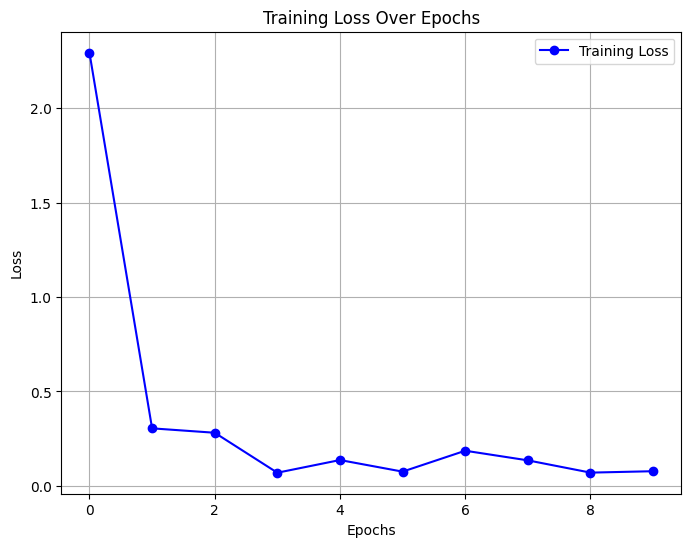

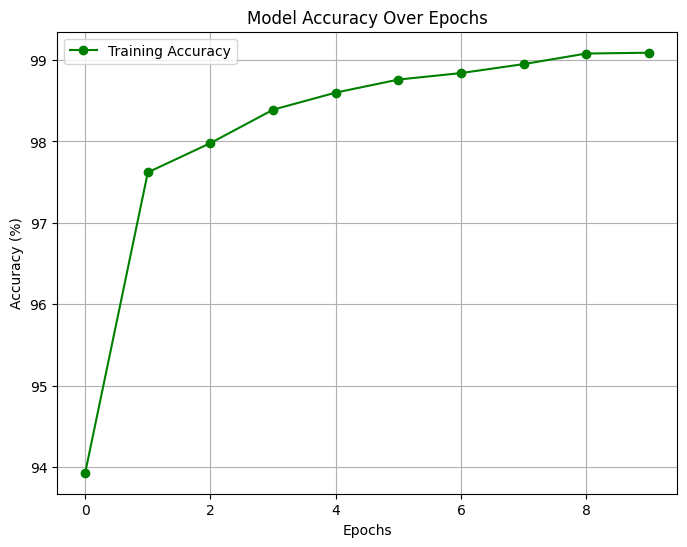

Evaluating the model on test set...
Final Test Accuracy: 99.12%


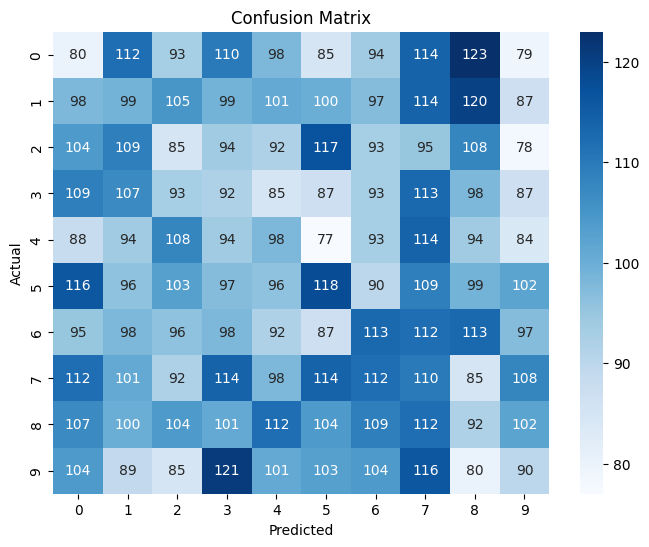

In [27]:
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1000, shuffle=True)

def show_sample_images():
    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)

    fig, axes = plt.subplots(3, 5, figsize=(8, 6))
    fig.suptitle("Sample Images from MNIST Dataset", fontsize=14)

    for i, ax in enumerate(axes.flat):
        ax.imshow(example_data[i][0], cmap='gray')
        ax.set_title(f"Label: {example_targets[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MNISTNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model, device


# Function to plot training loss
def plot_training_loss(training_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot accuracy
def plot_accuracy(accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(accuracies, label='Training Accuracy', color='green', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def main():
    model_path = "mnist_cnn.pt"
    model, device = load_model(model_path)

    # Display sample images
    show_sample_images()

    # Actual training losses from your provided data
    training_losses = [2.294886, 0.304469, 0.281143, 0.069344, 0.136560,
                       0.075088, 0.185885, 0.134861, 0.069875, 0.077341]
    plot_training_loss(training_losses)

    # Actual training accuracies from your provided data
    accuracies = [93.93, 97.62, 97.98, 98.39, 98.60, 98.76, 98.84, 98.95, 99.08, 99.09]
    plot_accuracy(accuracies)

    # Test the model and visualize confusion matrix
    final_accuracy, preds, labels = test_and_track(model, device, None)  # Pass test_loader if available
    print(f"Final Test Accuracy: {final_accuracy:.2f}%")

if __name__ == '__main__':
    main()

